In [105]:
import numpy as np
from numpy import ma
import xarray as xr
from glob import glob
from datetime import datetime, timedelta
from scipy import ndimage as ndi
from scipy import interpolate
from dateutil.parser import parse as parse_date
import argparse
from python_toolbox import abi_tools, dataset_tools, opt_flow
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# Getting files (on jasmin)

base_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/RadC/'

start_date = datetime(2018,6,19,16)
end_date = datetime(2018,6,19,20)
doy_start = (start_date - datetime(start_date.year, 1, 1)).days + 1
doy_end = (end_date - datetime(end_date.year, 1, 1)).days + 1

file_names = []
for year in range(start_date.year, end_date.year+1):
    year_str = str(year).zfill(4)
    if start_date.year == end_date.year:
        for doy in range(doy_start, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == start_date.year:
        for doy in range(doy_start, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == end_date.year:
        for doy in range(1, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    else:
        for doy in range(1, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))

# Get all filenames
goes_files = [abi_tools.get_goes_abi_files(f) for f in file_names]
# Filter for start and end date
goes_files = [f for f in goes_files if f[0] >= start_date and f[0] <= end_date and len(f) == 17]

len(goes_files)

47

In [3]:
# Get brightness temperature for channel 8,10,13 and 15
# Upper level water vapour (6.2um)
C8_data = abi_tools.get_abi_ds_from_files([f[8] for f in goes_files])[:,600:900,1300:1600]
# Lower level water vapour (7.3um)
C10_data = abi_tools.get_abi_ds_from_files([f[10] for f in goes_files])[:,600:900,1300:1600]
# Clean IR LW window channel(10.8um)
C13_data = abi_tools.get_abi_ds_from_files([f[13] for f in goes_files])[:,600:900,1300:1600]
# Dirty IR LW window channel(12.0um)
C15_data = abi_tools.get_abi_ds_from_files([f[15] for f in goes_files])[:,600:900,1300:1600]

dataset_tools.match_coords([C13_data,C10_data,C8_data,C15_data])


In [4]:
# water vapour and split window differences
wvd = C8_data - C10_data
swd = C13_data - C15_data


Text(0.5,1,'Split window difference')

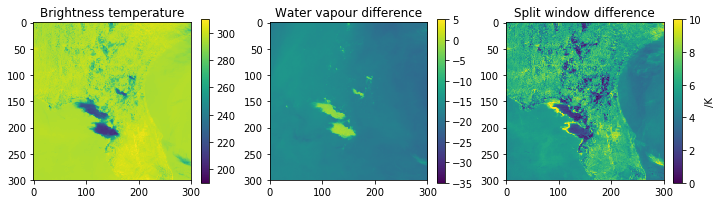

In [7]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
bt = ax[0].imshow(C13_data[24], vmin=190,vmax=310)
plt.colorbar(bt, ax=ax[0])
ax[0].set_title('Brightness temperature')

wv = ax[1].imshow(wvd[24], vmin=-35,vmax=5)
plt.colorbar(wv, ax=ax[1])
ax[1].set_title('Water vapour difference')

sw = ax[2].imshow(swd[24], vmin=0,vmax=10)
plt.colorbar(sw, label='/K', ax=ax[2])
ax[2].set_title('Split window difference')


Note that the split window temperatures are low in the middle of deep clouds, but high at the edges. I am using this to distinguish between the core and anvil parts of DCCs

In [8]:
field_flow = opt_flow.get_flow_func(C13_data, replace_missing=True)

Text(0.5,1,'Y flow vector')

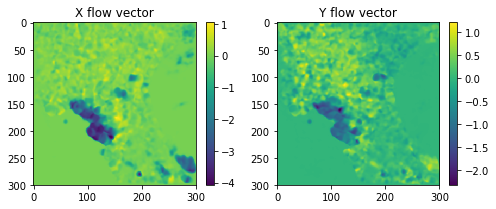

In [9]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
x_vec = ax[0].imshow(field_flow(1)[0][24])
plt.colorbar(x_vec, ax=ax[0])
ax[0].set_title('X flow vector')

y_vec = ax[1].imshow(field_flow(1)[1][24])
plt.colorbar(y_vec, ax=ax[1])
ax[1].set_title('Y flow vector')



## Semi-lagrangian BT cooling

In [10]:
# this gets a 3*arr.shape array of the field interpolated by one frame forwards and backwards
bt_stack = opt_flow.get_flow_stack(C13_data, field_flow).data.rechunk((3,1,300,300))

In [17]:
dx, dy = abi_tools.get_abi_pixel_lengths(C13_data)

In [18]:
# delta t, and also the spatial second derivative to find peaks in the brightness temperature
bt_dt = np.gradient(bt_stack, axis=0)[1]
bt_grad = np.gradient(np.gradient(bt_stack[1], axis=1), axis=1)/dy**2 + np.gradient(np.gradient(bt_stack[1], axis=2), axis=2)/dx**2

Text(0.5,1,'grad BT smoothed')

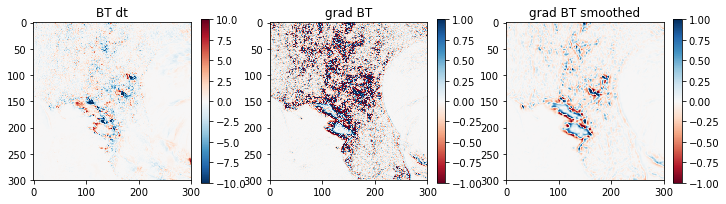

In [19]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
btdt = ax[0].imshow(bt_dt[24],vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar(btdt, ax=ax[0])
ax[0].set_title('BT dt')

gradbt = ax[1].imshow(bt_grad[24],vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar(gradbt, ax=ax[1])
ax[1].set_title('grad BT')

gradbts = ax[2].imshow(ndi.gaussian_filter(bt_grad[24],(1.5,1.5)),vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar(gradbts, ax=ax[2])
ax[2].set_title('grad BT smoothed')


By multiplying these fields we can get a metric for how much a peak in the BT field (positive grad) is growing (negative BTdt)

In [20]:
bt_growth = np.minimum(np.maximum(np.maximum(-bt_dt,0)
                                  * np.minimum(np.maximum(ndi.gaussian_filter(bt_grad,(0,1.5,1.5)),0),1),
                                  0),10)
# gaussian filter applied to grad bt to reduce noise

In [21]:
#dilate the field in a semi-lagrangian way
bt_growth_dilate = opt_flow.flow_convolve(
                       opt_flow.get_flow_stack(
                           xr.DataArray(bt_growth, dims=('t','y','x')), 
                           field_flow, method='linear').to_masked_array(), 
                       function=np.nanmax)

Text(0.5,1,'BT growth metric')

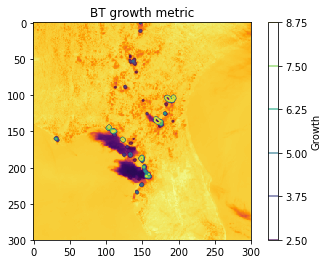

In [22]:
plt.imshow(C13_data[24],cmap='inferno',vmax=310,vmin=190)
plt.contour(bt_growth_dilate[24],np.arange(2.5,11.25,1.25), alpha=0.75)
# plt.gca().invert_yaxis()
plt.colorbar(label='Growth')
plt.title('BT growth metric')

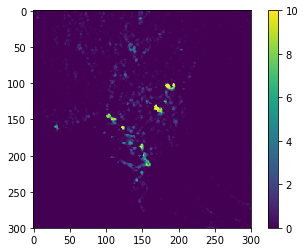

In [136]:
plt.imshow(bt_growth_dilate[24])
plt.colorbar()

I've found that 2.5 is a good value for this, it's approximately equal to a peak cooling of 0.5K/minute

In [57]:
bt_stack = opt_flow.get_flow_stack(C13_data, field_flow).data.rechunk((3,1,)+C13_data.shape[1:])
dx, dy = abi_tools.get_abi_pixel_lengths(C13_data)
bt_dt = np.gradient(bt_stack, axis=0)[1]
bt_grad = np.gradient(np.gradient(bt_stack[1], axis=1), axis=1)/dy**2 + np.gradient(np.gradient(bt_stack[1], axis=2), axis=2)/dx**2
bt_growth = np.minimum(np.maximum(np.maximum(-bt_dt,0)
                                  * np.minimum(np.maximum(ndi.gaussian_filter(bt_grad,(0,1.5,1.5)),0),1),
                                  0),10)
bt_growth = opt_flow.flow_convolve(
               opt_flow.get_flow_stack(
                   xr.DataArray(bt_growth, dims=('t','y','x')),
                   field_flow, method='linear').to_masked_array(),
               function=np.nanmax)


Text(0.5,1,'BT growth metric')

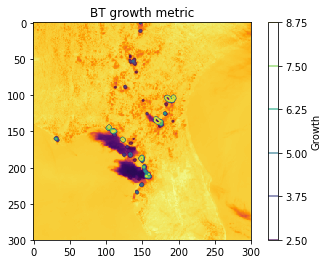

In [58]:
plt.imshow(C13_data[24],cmap='inferno',vmax=310,vmin=190)
plt.contour(bt_growth[24],np.arange(2.5,11.25,1.25), alpha=0.75)
# plt.gca().invert_yaxis()
plt.colorbar(label='Growth')
plt.title('BT growth metric')

New method multiplying x and y curvature fields rather than adding

In [173]:
# Testing new method
bt_stack = opt_flow.get_flow_stack(C13_data, field_flow).data.rechunk((3,1,)+C13_data.shape[1:])
dx, dy = abi_tools.get_abi_pixel_lengths(C13_data)
bt_dt = np.gradient(bt_stack, axis=0)[1]
# bt_grad = np.gradient(np.gradient(bt_stack[1], axis=1), axis=1)/dy**2 + np.gradient(np.gradient(bt_stack[1], axis=2), axis=2)/dx**2
bt_grad = (np.minimum(np.maximum(ndi.gaussian_filter(
                np.gradient(np.gradient(bt_stack[1], axis=1), axis=1)/dy**2,
                (0,1.5,1.5)), 0), 1) 
           * np.minimum(np.maximum(ndi.gaussian_filter(
                np.gradient(np.gradient(bt_stack[1], axis=2), axis=2)/dx**2,
                (0,1.5,1.5)), 0), 1))**0.5
# bt_growth = np.minimum(np.maximum(np.maximum(-bt_dt,0)
#                                   * np.minimum(np.maximum(ndi.gaussian_filter(bt_grad,(0,1.5,1.5)),0),1),
#                                   0),10)
bt_growth = np.minimum(np.maximum(np.maximum(-bt_dt,0) * bt_grad, 0),10)
bt_growth = opt_flow.flow_convolve(
               opt_flow.get_flow_stack(
                   xr.DataArray(bt_growth, dims=('t','y','x')),
                   field_flow, method='linear').to_masked_array(),
               function=np.nanmax)
print(type(bt_growth), bt_growth.dtype)


<class 'numpy.ma.core.MaskedArray'> float64


Text(0.5,1,'BT growth')

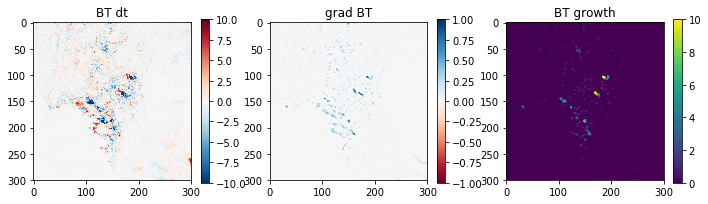

In [176]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
btdt = ax[0].imshow(bt_dt[24],vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar(btdt, ax=ax[0])
ax[0].set_title('BT dt')

gradbt = ax[1].imshow(bt_grad[24],vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar(gradbt, ax=ax[1])
ax[1].set_title('grad BT')

gradbts = ax[2].imshow(bt_growth[24], vmin=0, vmax=10)
plt.colorbar(gradbts, ax=ax[2])
ax[2].set_title('BT growth')


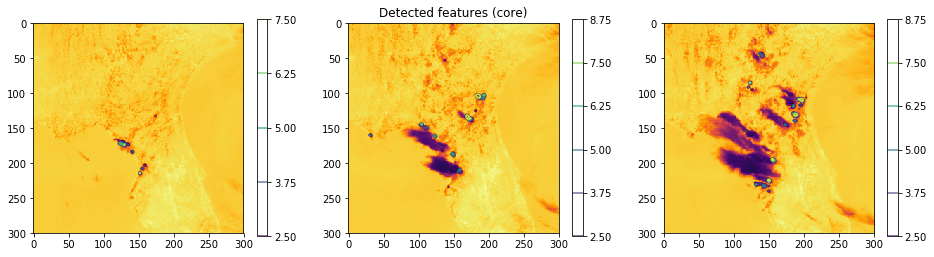

In [178]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],cmap='inferno',vmin=190,vmax=310)
c0 = ax[0].contour(bt_growth[12],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c0, ax=ax[0])

m1 = ax[1].imshow(C13_data[24],cmap='inferno',vmin=190,vmax=310)
c1 = ax[1].contour(bt_growth[24],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('Detected features (core)')

m2 = ax[2].imshow(C13_data[36],cmap='inferno',vmin=190,vmax=310)
c2 = ax[2].contour(bt_growth[36],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c2, ax=ax[2])


In [179]:
upper_thresh = -5
lower_thresh = -15

print(datetime.now(), 'Calculating markers')
markers = wvd>upper_thresh
markers = np.logical_and(markers, bt_growth>2.5).compute().to_masked_array()

2019-12-05 13:16:41.805928 Calculating markers


In [180]:
type(markers)

numpy.ma.core.MaskedArray

## Semi-lagrangian watershedding

In [181]:
upper_thresh = -5
lower_thresh = -15
markers = wvd>upper_thresh
markers = np.logical_and(markers, bt_growth>2.5).compute().to_masked_array()
mask = (wvd<lower_thresh).compute().to_masked_array()
for i in range(np.minimum(3, (mask.shape[0]-1)//2)):
    # Semi-lagrangian erosion of the mask by up to three steps
    mask = opt_flow.flow_convolve(opt_flow.get_flow_stack(xr.DataArray(mask, dims=('t','y','x')), 
                                  field_flow, method='nearest').to_masked_array(), 
                                  function=np.nanmin)

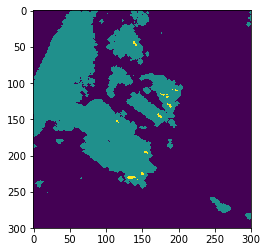

In [209]:
plt.imshow((markers.astype(int)-mask.astype(int))[36])

Markers in yellow. Mask in dark blue. Unfilled regions are in teal

In [183]:
# Sobel edge detection for watershedding. Combine WVD, SWD and growth to find regions
inner_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve( 
                                                  opt_flow.get_flow_stack((wvd-swd+bt_growth_dilate-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


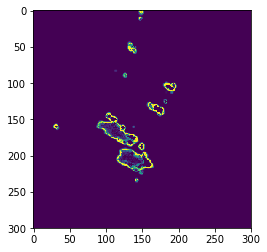

In [184]:
plt.imshow(inner_edges[24],vmin=0,vmax=50)

In [229]:
from importlib import reload; reload(opt_flow)

<module 'python_toolbox.opt_flow' from '/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py'>

In [230]:
# Watershed
features = opt_flow.flow_network_watershed(inner_edges, markers, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating field stack
Calculating indices stack
Calculating nearest neighbours
<class 'numpy.ndarray'> bool
Finding network convergence locations
Iteration: 1
Pixels converged 613048
Iteration: 2
Pixels converged 986849
Iteration: 3
Pixels converged 1459349
Iteration: 4
Pixels converged 1961251
Iteration: 5
Pixels converged 2504851
Iteration: 6
Pixels converged 3224944
Iteration: 7
Pixels converged 3919882
Iteration: 8
Pixels converged 4225850
Iteration: 9
Pixels converged 4230000
All pixels converged
Filling basins
Joining labels
max_markers: True
Iteration: 1
Remaining labels: 1390
Max label: 10700
Labels: [ 0  1  2  3 18 23 24 25 26 28]
New: [ 210 5786    3    3   18   25   25   25   26   28]
Iteration: 2
Remaining labels: 215
Max label: 10276
Labels: [  0   1  25 126 152 182 203 268 279 486]
New: [  18 4064   25  152  152  182  279  268  279  486]
Iteration: 3
Remaining labels: 44
Max label: 9015
Labels: [   0    1 4188 4618 4631 4716 4778 4796 5011 5013]
New: [ 565 7096 4188 477

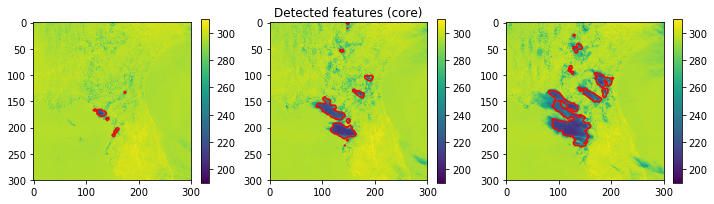

In [231]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(features[12],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(features[24],[0.5],colors=['red'])
ax[1].set_title('Detected features (core)')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(features[36],[0.5],colors=['red'])


Repeat for outer regions

In [187]:

outer_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve(
                                                  opt_flow.get_flow_stack((wvd+swd+bt_growth_dilate-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


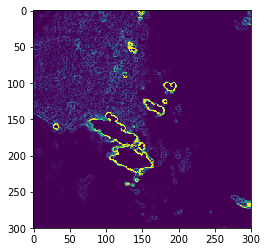

In [188]:
plt.imshow(outer_edges[24],vmin=0,vmax=50)

In [189]:
# Watershed
outer = opt_flow.flow_network_watershed(outer_edges, features, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating field stack
Calculating indices stack
Calculating nearest neighbours
<class 'numpy.ma.core.MaskedArray'> int16
Finding network convergence locations
Iteration: 1
Pixels converged 1103543
Iteration: 2
Pixels converged 1925905
Iteration: 3
Pixels converged 2597333
Iteration: 4
Pixels converged 3044984
Iteration: 5
Pixels converged 3465056
Iteration: 6
Pixels converged 3904925
Iteration: 7
Pixels converged 4158617
Iteration: 8
Pixels converged 4229985
Iteration: 9
Pixels converged 4230000
All pixels converged
Filling basins
Joining labels
max_markers: 1
Iteration: 1
Remaining labels: 5608
Max label: 28104
Labels: [ 0  1  2  6  9 20 25 27 28 29]
New: [15233 11997     2     6    50    20    54    28    54    29]
Iteration: 2
Remaining labels: 1076
Max label: 27884
Labels: [  0   1   9  34  35  58  65  95 110 112]
New: [14155  6301     9    35    35    58    65    95   110   112]
Iteration: 3
Remaining labels: 214
Max label: 25524
Labels: [  0   1 490 603 632 712 723 770 813 814]

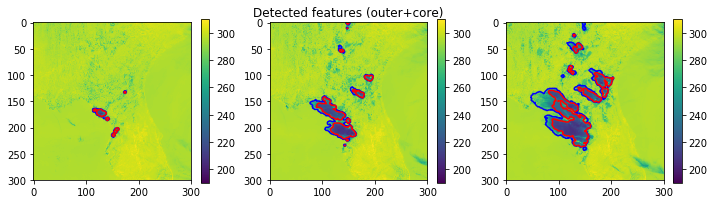

In [190]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(outer[12],[0.5],colors=['blue'])
ax[0].contour(features[12],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(outer[24],[0.5],colors=['blue'])
ax[1].contour(features[24],[0.5],colors=['red'])
ax[1].set_title('Detected features (outer+core)')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(outer[36],[0.5],colors=['blue'])
ax[2].contour(features[36],[0.5],colors=['red'])


The 'outer' region seems to pick up the extent of the anvil outflow fairly well

Picking out the mean brightness temperature of each region at each step and plotting one. Looks reasonable

In [191]:
inner_labels = ndi.label(features)[0]
bt_labels = [[np.nanmean(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

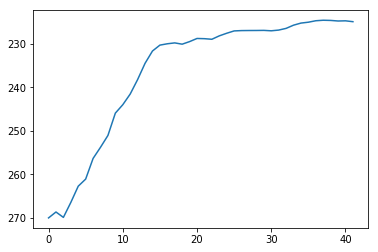

In [192]:
plt.plot(bt_labels[0])
plt.gca().invert_yaxis()

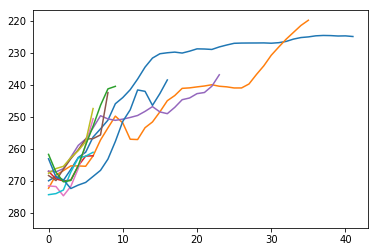

In [193]:
for i in range(len(bt_labels)):
    plt.plot(bt_labels[i])
plt.gca().invert_yaxis()

In [194]:
outer_labels = ndi.label(outer)[0]
bt_labels2 = [[np.nanmean(C13_data[j].data.ravel()[(outer_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(outer_labels[j]==i)] 
             for i in np.arange(1,outer_labels.max()+1)]

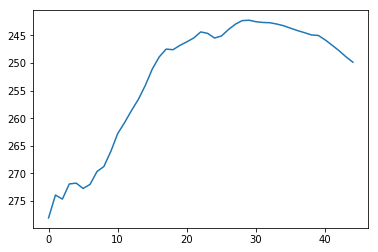

In [195]:
plt.plot(bt_labels2[0])
plt.gca().invert_yaxis()

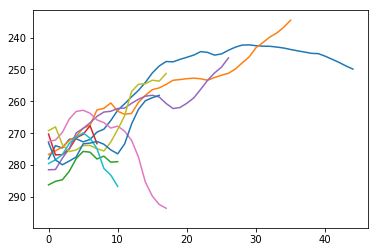

In [196]:
for i in range(len(bt_labels2)):
    plt.plot(bt_labels2[i])
plt.gca().invert_yaxis()

In [197]:
inner_labels = ndi.label(features)[0]
max_labels = [[np.nanmin(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

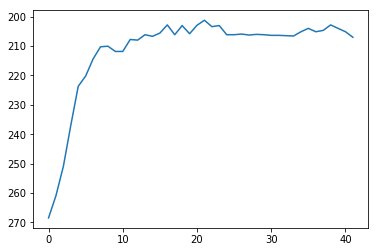

In [198]:
plt.plot(max_labels[0])
plt.gca().invert_yaxis()

In [199]:
inner_labels = ndi.label(features)[0]
growth_labels = [[np.nanmax(bt_growth[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

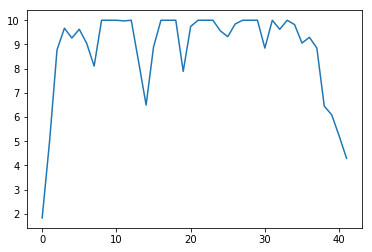

In [200]:
plt.plot(growth_labels[0])
# plt.gca().invert_yaxis()

In [201]:
inner_labels = ndi.label(features)[0]
growth_labels = [[np.nanmean(bt_growth[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

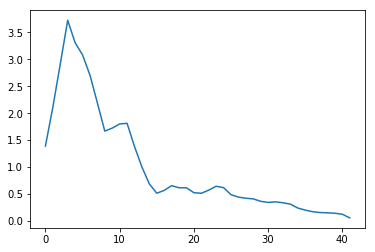

In [202]:
plt.plot(growth_labels[0])
# plt.gca().invert_yaxis()

Comparison with GLM data

In [64]:
glm_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/170/*'
glm_files = glob(glm_path+'/OR_GLM-L2-LCFA_*.nc')
glm_files.sort()
glm_dates = [abi_tools.get_abi_date_from_filename(f) for f in glm_files]
glm_dates_array = np.array(glm_dates)

In [65]:
glm_files[0]

'/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/170/00/OR_GLM-L2-LCFA_G16_s20181700000000_e20181700000200_c20181700000226.nc'

In [71]:
p = abi_tools.get_abi_proj(C13_data[0])
height=C13_data[0].goes_imager_projection.perspective_point_height

In [98]:
# Get lightning event and flash locations
event_x = []
event_y = []
flash_x = []
flash_y = []
for abi_file in goes_files:
#     abi_file = goes_files[f_ind]
    wh_dates = np.all([glm_dates_array>=abi_file[0], glm_dates_array<(abi_file[0]+timedelta(minutes=5))], axis=0)
    matched_glm_files = np.array(glm_files)[wh_dates]
    t_event_x = []
    t_event_y = []
    t_flash_x = []
    t_flash_y = []
    for glm_file in matched_glm_files:
        with xr.open_dataset(glm_file) as glm_ds:
            temp_x, temp_y = (output/height for output in p(glm_ds.event_lon.data, glm_ds.event_lat.data))
            t_event_x.append(temp_x)
            t_event_y.append(temp_y)
            temp_x, temp_y = (output/height for output in p(glm_ds.flash_lon.data, glm_ds.flash_lat.data))
            t_flash_x.append(temp_x)
            t_flash_y.append(temp_y)

    event_x.append(np.concatenate(t_event_x))
    event_y.append(np.concatenate(t_event_y))
    flash_x.append(np.concatenate(t_flash_x))
    flash_y.append(np.concatenate(t_flash_y))

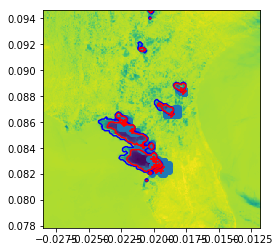

In [203]:
plt.imshow(C13_data[f_ind], extent=(C13_data[0].x[0].item(),
                                C13_data[0].x[-1].item(),
                                C13_data[0].y[-1].item(),
                                C13_data[0].y[0].item()))
plt.contour(C13_data[0].x, C13_data[0].y, outer[f_ind],[0.5],colors=['blue'])
plt.contour(C13_data[0].x, C13_data[0].y, features[f_ind],[0.5],colors=['red'])

wh = np.all([event_x[f_ind]>=C13_data[0].x[0].item(),
             event_x[f_ind]<=C13_data[0].x[-1].item(),
             event_y[f_ind]>=C13_data[0].y[-1].item(),
             event_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(event_x[f_ind][wh], event_y[f_ind][wh])
wh = np.all([flash_x[f_ind]>=C13_data[0].x[0].item(),
             flash_x[f_ind]<=C13_data[0].x[-1].item(),
             flash_y[f_ind]>=C13_data[0].y[-1].item(),
             flash_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(flash_x[f_ind][wh], flash_y[f_ind][wh], c='r', marker='+')


In [204]:
outer_dist = ndi.distance_transform_edt(np.logical_not(outer))

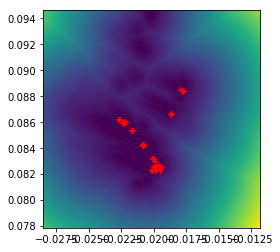

In [205]:
plt.imshow(outer_dist[f_ind], extent=(C13_data[0].x[0].item(),
                                C13_data[0].x[-1].item(),
                                C13_data[0].y[-1].item(),
                                C13_data[0].y[0].item()))
# plt.colorbar()
wh = np.all([flash_x[f_ind]>=C13_data[0].x[0].item(),
             flash_x[f_ind]<=C13_data[0].x[-1].item(),
             flash_y[f_ind]>=C13_data[0].y[-1].item(),
             flash_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(flash_x[f_ind][wh], flash_y[f_ind][wh], c='r', marker='+')


In [206]:
dist_test = interpolate.interpn((C13_data[0].y[::-1], C13_data[0].x),
                                outer_dist[f_ind][::-1],
                                np.stack([flash_y[f_ind], flash_x[f_ind]], axis=-1),
                                method='linear',
                                bounds_error=False,
                                fill_value=np.nan)

In [207]:
outer_dists = []
for i in range(outer_dist.shape[0]):
    outer_dists.append(interpolate.interpn((C13_data[0].y[::-1], C13_data[0].x),
                                outer_dist[i][::-1],
                                np.stack([flash_y[i], flash_x[i]], axis=-1),
                                method='linear',
                                bounds_error=False,
                                fill_value=np.nan))
outer_dists = np.concatenate(outer_dists)
outer_dists = ma.array(outer_dists, mask=np.isnan(outer_dists))

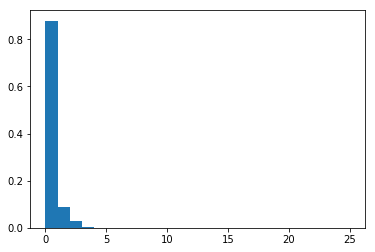

In [208]:
h = plt.hist(outer_dists, bins=np.arange(0,26), density=True,stacked=True)

In [127]:
plt.hist?

In [213]:
ndi.generate_binary_structure(3,2)

array([[[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

In [223]:
isinstance(ma.array([0]), ma.core.MaskedArray)

True

In [222]:
type(ma.array([0]))

numpy.ma.core.MaskedArray

In [224]:
hasattr(ma.array([0]), 'data')

True

In [232]:
np.logical_not(np.logical_or(markers, mask))

masked_array(
  data=[[[True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         ...,
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True]],

        [[True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         ...,
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True]],

        [[True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         ...,
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True]],

  